In [1]:
import pickle
import psutil
import sys
from pathlib import Path
from typing import Dict, List, Union

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, TargetEncoder
from tabpfn import TabPFNRegressor
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNRegressor
from xgboost import XGBRegressor
from yellowbrick.regressor import ResidualsPlot


from fwi_predict.constants import TZ_STRING, WQ_RANGES
from fwi_predict.wq import get_in_required_range

sys.path.append("..")
from scripts.clean_ara_measurements import column_map

In [2]:
# Load data and remove columns that we don't want for training
predict_df = pd.read_csv("../data/predict_dfs/train/jun_21_dec_24_w_metadata_predict_df.csv",
                         parse_dates=['sample_dt'],
                         index_col=0)

num_sum_cols = predict_df.columns[predict_df.columns.str.contains('num_sum')].tolist()
drop_cols = ['sample_idx', 'geometry'] + num_sum_cols
predict_df = predict_df.drop(columns=drop_cols)

# Get parameters for classification problem
predict_df['morning'] = predict_df['hour'] < 12
predict_df['month'] = predict_df['sample_dt'].dt.month

predict_df = predict_df.drop(columns=['ammonia_mg_per_L', 'ph', 'turbidity_cm'])
predict_df['do_in_range'] = get_in_required_range('do_mg_per_L',
                                                  predict_df['do_mg_per_L'], 
                                                  predict_df['morning'].apply(lambda x: 'morning' if x else 'evening'))
                                                  

In [3]:
predict_df.columns.tolist()

['sample_dt',
 'pond_id',
 'region',
 'farm',
 'morning',
 'hour',
 'do_mg_per_L',
 'do_winkler',
 'prev_matches_time',
 'prev_sample_dt',
 'prev_do_mg_per_L',
 'prev_ph',
 'prev_turbidity_cm',
 'prev_ammonia_mg_per_L',
 'prev_individuals_air_gulping',
 'prev_individuals_tail_splashing',
 'prev_dead_fish',
 'prev_feed_amount_kg',
 'prev_stocking_density_per_acre',
 'prev_weight',
 'prev_species_catla',
 'prev_species_rohu',
 'prev_species_roopchand',
 'prev_species_grass_carp',
 'prev_species_pangasius',
 'prev_species_whiteleg_shrimp',
 'property_area_acres',
 'pond_area_acres',
 'pond_depth_meters',
 'has_water_pump',
 'has_aerator',
 'has_motor_boat',
 'has_sprinkler',
 'pond_preparation',
 'village',
 'fertilizer_manure',
 'fertilizer_dap',
 'fertilizer_potash',
 'fertilizer_urea',
 'fertilizer_phosphate',
 'fertilizer_amm_sulph',
 'fertilizer_probiotics',
 'fertilizer_magnesium',
 'fertilizer_gromor',
 'fertilizer_lime',
 'fertilizer_none',
 'feed_type',
 'feed_source',
 'feed_bra

In [4]:
predict_df['do_in_range'].value_counts(dropna=True)

do_in_range
within    4847
below      630
above      158
            10
Name: count, dtype: int64

In [5]:
predict_df['date'] = predict_df['sample_dt'].dt.date
predict_df['region'] = predict_df['pond_id'].str[:2]

In [6]:
winkler_df = predict_df[predict_df['do_winkler']]
taiwan_df = predict_df[~predict_df['do_winkler']]
len(winkler_df)

1417

In [7]:
winkler_df['do_in_range'].value_counts() * 100 / len(winkler_df)

do_in_range
within    93.507410
below      4.728299
above      1.764291
Name: count, dtype: float64

These should roughly be our minimum targets for model precision

In [8]:
target = 'do_mg_per_L'

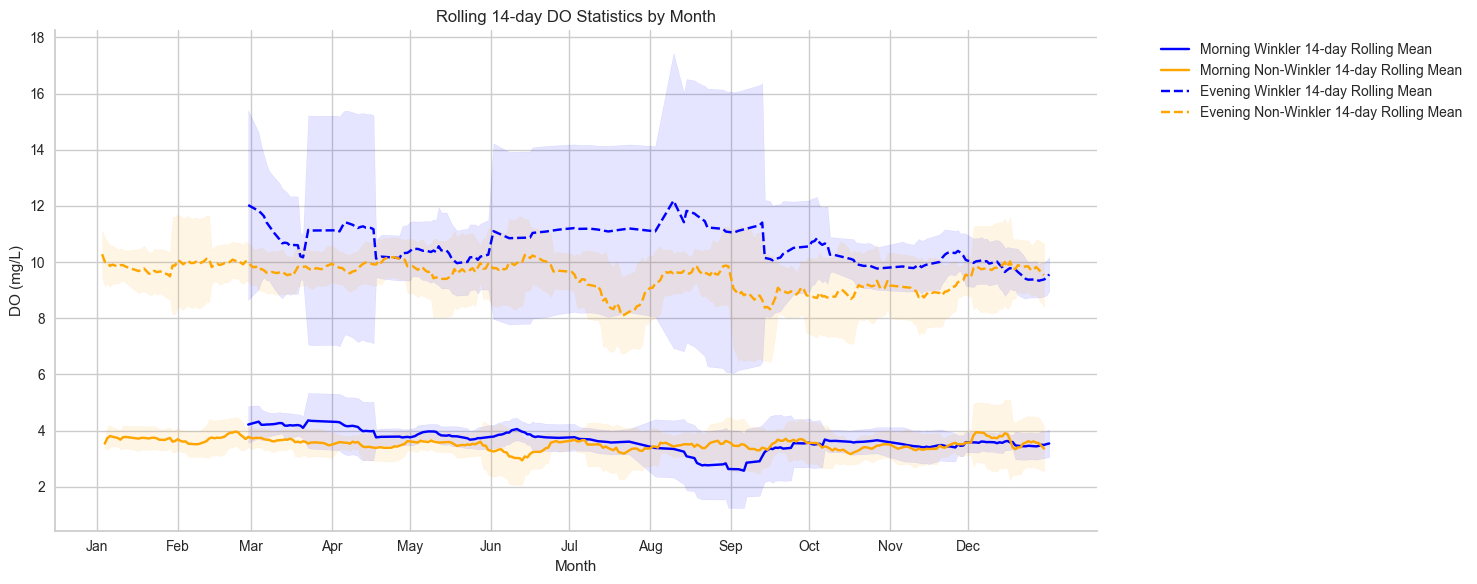


Summary Statistics for All DO Measurements:


,time_of_day,measurement_type,mean,std,count
0,Morning,Winkler,3.628909,0.804203,761.0
1,Morning,Non-Winkler,3.512698,1.028554,2142.0
2,Evening,Winkler,10.224848,2.026355,656.0
3,Evening,Non-Winkler,9.546965,1.879091,2076.0


In [9]:
# Function to calculate rolling averages for DO measurements
def calculate_rolling_averages(df, window_size=7):
    """
    Calculate rolling window averages for dissolved oxygen measurements,
    separated by morning/evening and measurement type.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing DO measurements with 'morning' and 'winkler' columns
    window_size : int, default=7
        Size of the rolling window in days
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with rolling averages for each group
    """
    # Create a copy to avoid SettingWithCopyWarning
    result_df = df.copy()
    
    # Add day of year column
    result_df['day_of_year'] = result_df['sample_dt'].dt.dayofyear
    
    # Ensure data is sorted by day of year
    result_df = result_df.sort_values('day_of_year')
    
    # Calculate rolling statistics for each combination of morning/evening and winkler/non-winkler
    groups = []
    for is_morning in [True, False]:
        for is_winkler in [True, False]:
            data = result_df[(result_df['morning'] == is_morning) & 
                           (result_df['do_winkler'] == is_winkler)]
            
            daily_means = data.groupby(['day_of_year'])['do_mg_per_L'].mean()
            rolling_mean = daily_means.rolling(window=window_size, min_periods=3).mean()
            rolling_std = daily_means.rolling(window=window_size, min_periods=3).std()
            
            groups.append({
                'data': rolling_mean,
                'std': rolling_std,
                'label': f'{"Morning" if is_morning else "Evening"} {"Winkler" if is_winkler else "Non-Winkler"}',
                'color': 'blue' if is_winkler else 'orange',  # Same color for same measurement type
                'linestyle': '-' if is_morning else '--'
            })

    # Plot the results
    fig, ax = plt.subplots(figsize=(15, 6))
    
    for group in groups:
        group['data'].plot(ax=ax, 
                         label=f"{group['label']} {window_size}-day Rolling Mean", 
                         color=group['color'],
                         linestyle=group['linestyle'])
        ax.fill_between(group['data'].index, 
                       group['data'] - group['std'],
                       group['data'] + group['std'],
                       alpha=0.1, 
                       color=group['color'])
    
    # Set x-axis ticks to show months
    month_ticks = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]  # Approximate middle of each month
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(month_ticks)
    ax.set_xticklabels(month_labels)
    
    ax.set_title(f'Rolling {window_size}-day DO Statistics by Month')
    ax.set_xlabel('Month')
    ax.set_ylabel('DO (mg/L)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    plt.show()

    # Calculate summary statistics
    summary_stats = []
    for is_morning in [True, False]:
        for is_winkler in [True, False]:
            data = result_df[(result_df['morning'] == is_morning) & 
                           (result_df['do_winkler'] == is_winkler)]
            stats = data['do_mg_per_L'].agg(['mean', 'std', 'count']).to_dict()
            stats['time_of_day'] = 'Morning' if is_morning else 'Evening'
            stats['measurement_type'] = 'Winkler' if is_winkler else 'Non-Winkler'
            summary_stats.append(stats)
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df = summary_df[['time_of_day', 'measurement_type', 'mean', 'std', 'count']]
    
    print("\nSummary Statistics for All DO Measurements:")
    display(summary_df)

# Calculate rolling averages with 7-day window
rolling_window = 14
calculate_rolling_averages(predict_df, window_size=rolling_window)


In [10]:
# Create interactive plot of DO over time by pond
# Get all ponds ordered by number of observations
pond_order = winkler_df.groupby('pond_id').size().sort_values(ascending=False).index.tolist()
winkler_df['date'] = winkler_df['sample_dt'].dt.date

# Get top 10 ponds for initial visibility
top_10_ponds = pond_order[:10]

fig = px.line(winkler_df, 
                 x='date', 
                 y='do_mg_per_L',
                 color='pond_id',
                 facet_row='morning',
                 title='Dissolved Oxygen Over Time by Pond',
                 labels={'do_mg_per_L': 'Dissolved Oxygen (mg/L)',
                        'date': 'Date',
                        'pond_id': 'Pond ID',
                        'morning': 'Morning'},
                 category_orders={'pond_id': pond_order},
                 height=800)

# Add shaded regions for required DO ranges based on time of day
# Morning range (3-5 mg/L)
fig.add_hrect(y0=3, y1=5,
              fillcolor="green", opacity=0.2,
              layer="below", line_width=0,
              annotation_text="Required Range",
              annotation_position="top right",
              row=2)  # Morning facet

# Evening range (8-12 mg/L) 
fig.add_hrect(y0=8, y1=12,
              fillcolor="green", opacity=0.2,
              layer="below", line_width=0,
              annotation_text="Required Range",
              annotation_position="top right",
              row=1)  # Evening facet

# Update layout
fig.update_layout(
    showlegend=True,
    legend_title_text='Pond ID',
    title_x=0.5,
    height=800  # Increased height for better visibility
)

# Show only top 10 ponds initially but allow selection of others
fig.for_each_trace(lambda t: t.update(visible='legendonly') 
                   if t.name not in top_10_ponds 
                   else t.update(visible=True))

fig.show()


C:\Users\squaade\AppData\Local\Temp\ipykernel_33836\4021004876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winkler_df['date'] = winkler_df['sample_dt'].dt.date


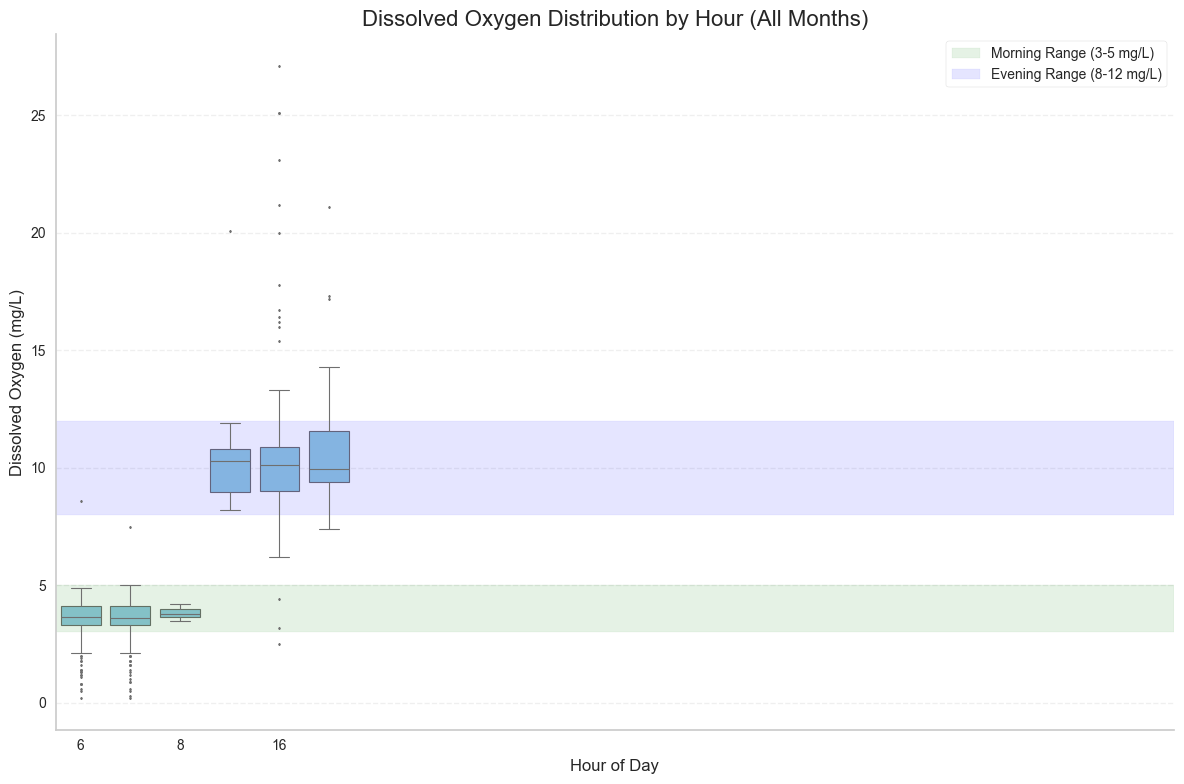

In [11]:
# Create a figure for boxplots of dissolved oxygen by hour (not disaggregated by month)
plt.figure(figsize=(12, 8))

# Create boxplot of DO by hour
ax = sns.boxplot(x='hour', y='do_mg_per_L', data=winkler_df, 
                color='skyblue', fliersize=1, linewidth=0.8,
                order=sorted(winkler_df['hour'].unique()))  # Sort hours numerically

# Customize the appearance
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Dissolved Oxygen (mg/L)', fontsize=12)
plt.title('Dissolved Oxygen Distribution by Hour (All Months)', fontsize=16)
plt.xticks(range(0, 24, 2))  # Set x-ticks every 2 hours

# Remove spines to make it prettier
sns.despine(left=False, bottom=False)

# Add light grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add shaded regions for required DO ranges
plt.axhspan(3, 5, alpha=0.1, color='green', label='Morning Range (3-5 mg/L)')
plt.axhspan(8, 12, alpha=0.1, color='blue', label='Evening Range (8-12 mg/L)')

# Add legend
plt.legend(loc='best', frameon=True)

# Adjust layout
plt.tight_layout()
plt.show()


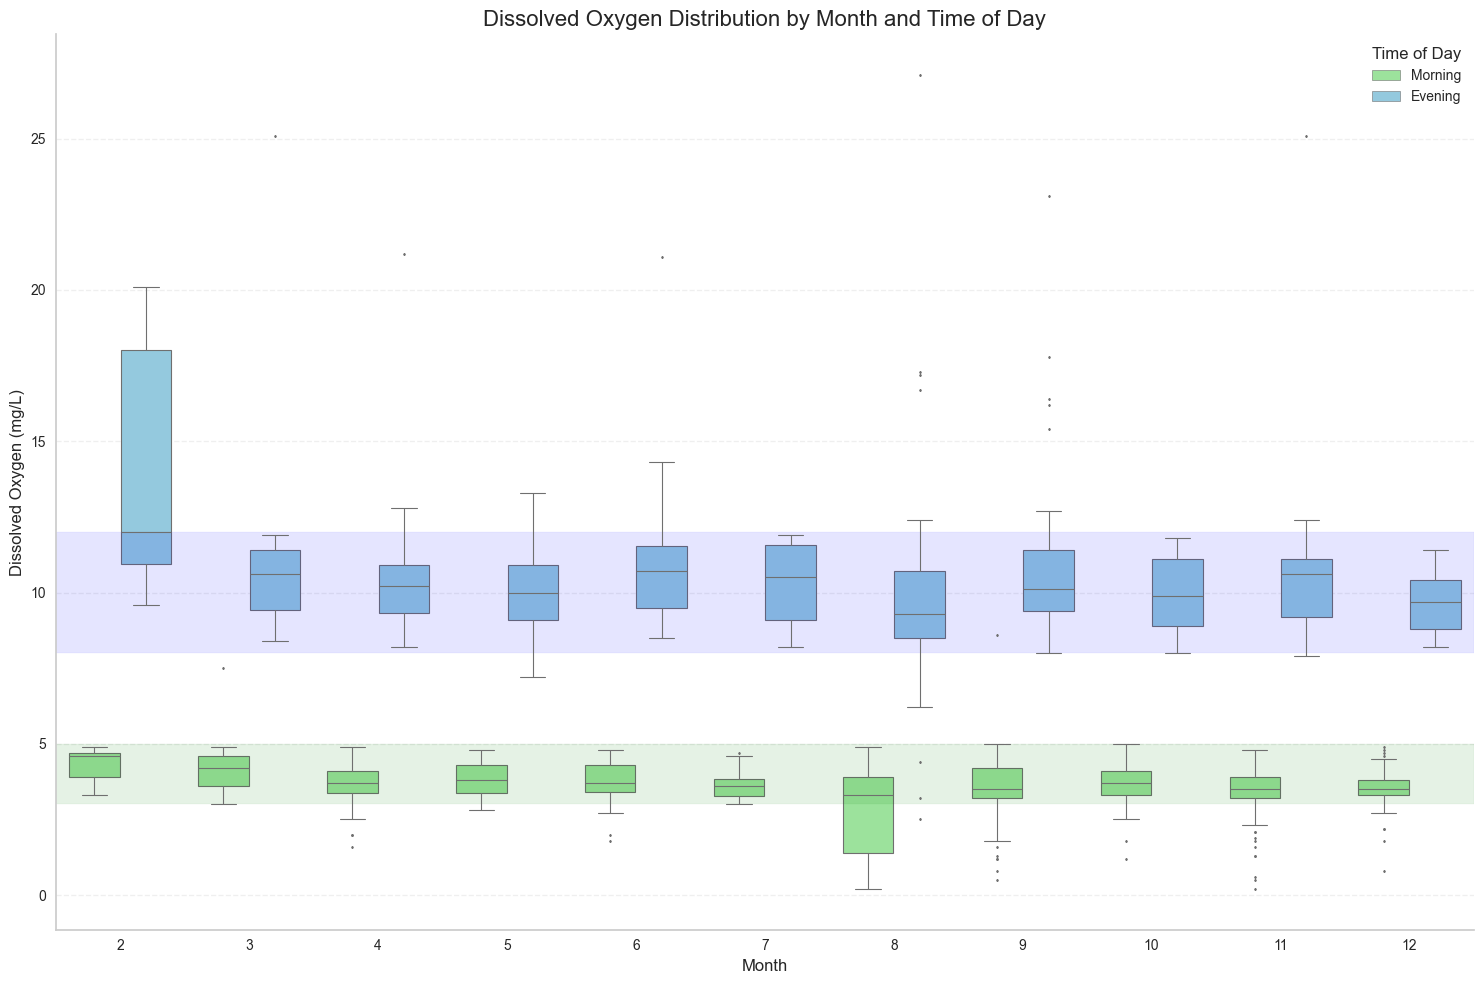

In [12]:
# Create a figure for boxplots of dissolved oxygen by month, hued by time of day
plt.figure(figsize=(15, 10))

# Create a new column to categorize time as morning or evening for this visualization
winkler_df_viz = winkler_df.copy()
winkler_df_viz['time_of_day'] = 'Evening'
winkler_df_viz.loc[winkler_df_viz['hour'] < 12, 'time_of_day'] = 'Morning'

# Create boxplot of DO by month, with time of day as hue
ax = sns.boxplot(x='month', y='do_mg_per_L', hue='time_of_day', data=winkler_df_viz, 
                 palette={'Morning': 'lightgreen', 'Evening': 'skyblue'},
                 fliersize=1, linewidth=0.8)

# Customize the appearance
plt.xlabel('Month', fontsize=12)
plt.ylabel('Dissolved Oxygen (mg/L)', fontsize=12)
plt.title('Dissolved Oxygen Distribution by Month and Time of Day', fontsize=16)

# Adjust legend
plt.legend(title='Time of Day', loc='best')

# Remove spines to make it prettier
sns.despine(left=False, bottom=False)

# Add light grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add shaded regions for required DO ranges
plt.axhspan(3, 5, alpha=0.1, color='green', label='Morning Range (3-5 mg/L)')
plt.axhspan(8, 12, alpha=0.1, color='blue', label='Evening Range (8-12 mg/L)')

# Adjust layout
plt.tight_layout()
plt.show()



C:\Users\squaade\AppData\Local\Temp\ipykernel_33836\1165434181.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



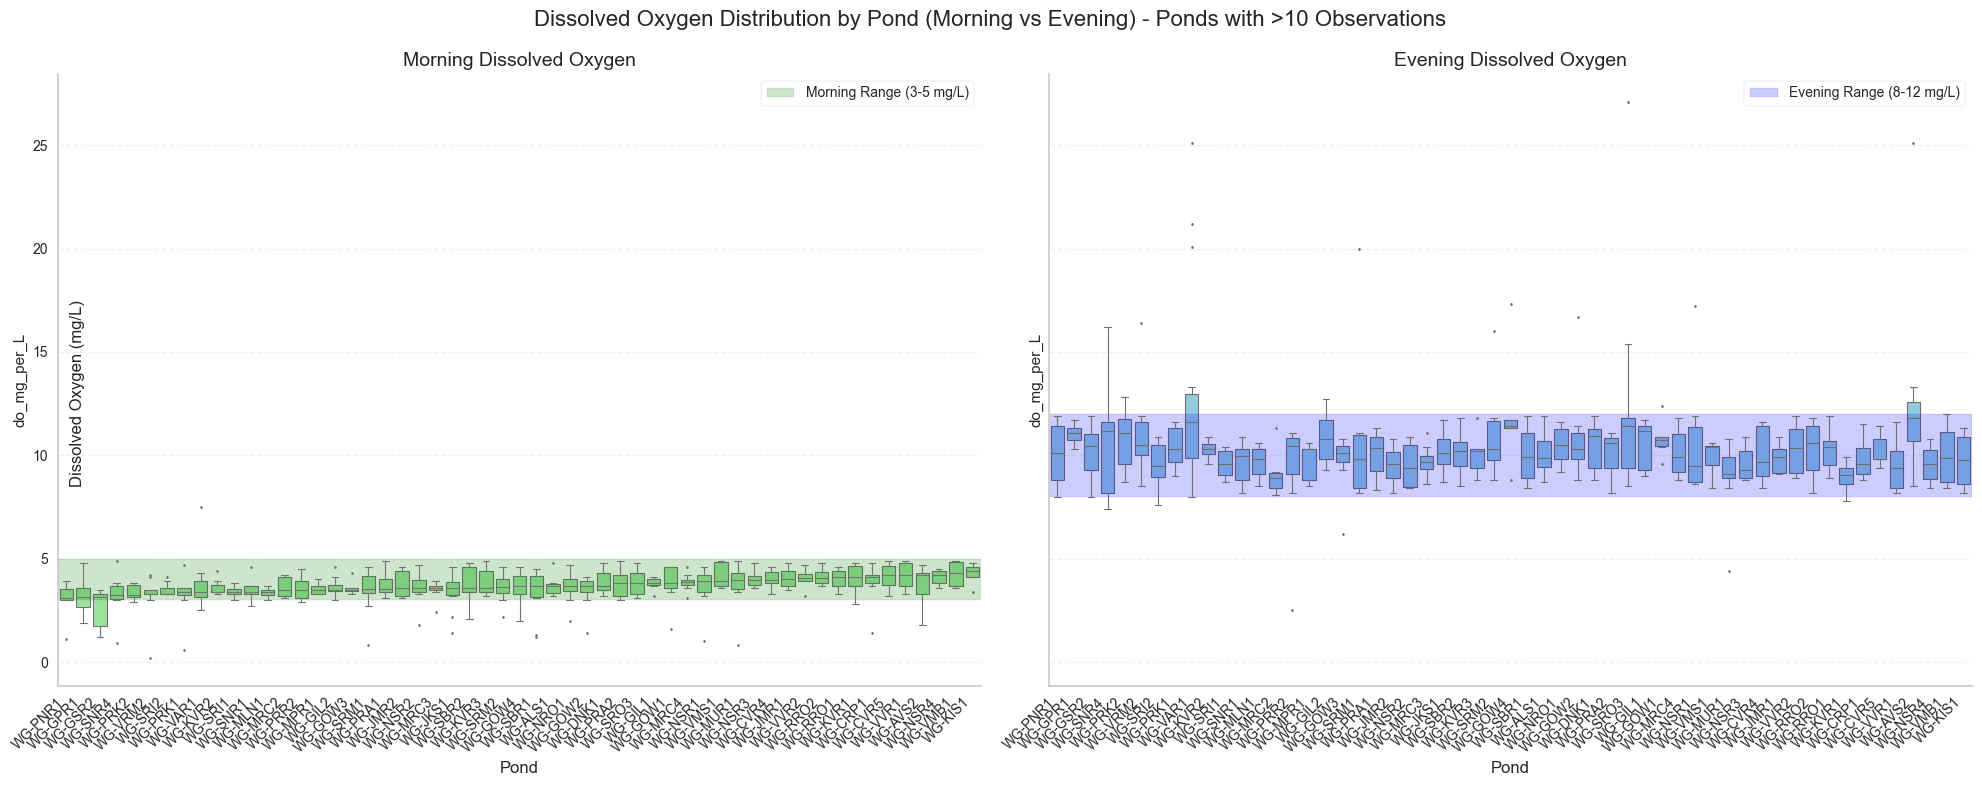

In [13]:
# Create a new column to categorize time as morning or evening
winkler_df['time_of_day'] = 'Evening'
winkler_df.loc[winkler_df['hour'] < 12, 'time_of_day'] = 'Morning'

# Count observations per pond
pond_counts = winkler_df.groupby('pond_id').size()
valid_ponds = pond_counts[pond_counts > 10].index.tolist()

# Filter to only include ponds with more than 10 observations
filtered_df = winkler_df[winkler_df['pond_id'].isin(valid_ponds)]

# Calculate medians for sorting by morning values
morning_medians = filtered_df[filtered_df['time_of_day'] == 'Morning'].groupby('pond_id')['do_mg_per_L'].median()
pond_order = morning_medians.sort_values().index.tolist()

# Create a figure for faceted boxplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Colors for each time of day
colors = {'Morning': 'lightgreen', 'Evening': 'skyblue'}

# Create separate boxplots for morning and evening
for i, time_period in enumerate(['Morning', 'Evening']):
    # Filter data for this time period
    period_data = filtered_df[filtered_df['time_of_day'] == time_period]
    
    # Create boxplot
    sns.boxplot(x='pond_id', y='do_mg_per_L', 
                data=period_data, 
                color=colors[time_period],
                fliersize=1, linewidth=0.8,
                order=pond_order,
                ax=axes[i])
    
    # Customize appearance
    axes[i].set_xlabel('Pond', fontsize=12)
    axes[i].set_title(f'{time_period} Dissolved Oxygen', fontsize=14)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    # Remove spines
    sns.despine(ax=axes[i], left=False, bottom=False)
    
    # Add grid
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add appropriate shaded region for required DO range
    if time_period == 'Morning':
        axes[i].axhspan(3, 5, alpha=0.2, color='green', label='Morning Range (3-5 mg/L)')
    else:
        axes[i].axhspan(8, 12, alpha=0.2, color='blue', label='Evening Range (8-12 mg/L)')
    
    # Add legend
    axes[i].legend(loc='best', frameon=True)

# Set common y-label
fig.text(0.04, 0.5, 'Dissolved Oxygen (mg/L)', va='center', rotation='vertical', fontsize=12)

# Add overall title
plt.suptitle('Dissolved Oxygen Distribution by Pond (Morning vs Evening) - Ponds with >10 Observations', fontsize=16, y=0.98)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [14]:
# Create half hour period from sample_dt (0-47 representing each 30 min period in day)
predict_df['half_hour'] = (predict_df['sample_dt'].dt.hour * 2 + (predict_df['sample_dt'].dt.minute >= 30).astype(int))

In [15]:
# Calculate rolling averages and variations for morning and evening
def plot_rolling_stats(df, window=7):
    """
    Plot rolling statistics for DO levels, separated by morning and evening.
    
    Args:
        df: DataFrame with DO measurements
        window: Rolling window size in days
    """
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Define morning and evening periods
    # Morning: 6am-12pm, Evening: 6pm-12am
    morning_mask = (df['sample_dt'].dt.hour < 12)
    evening_mask = (df['sample_dt'].dt.hour >= 12)
    
    # Calculate rolling statistics for morning
    morning_data = df[morning_mask]
    morning_daily_means = morning_data.groupby(['date'])['do_mg_per_L'].mean()
    morning_rolling_mean = morning_daily_means.rolling(window=window).mean()
    morning_rolling_std = morning_daily_means.rolling(window=window).std()
    
    # Calculate rolling statistics for evening
    evening_data = df[evening_mask]
    evening_daily_means = evening_data.groupby(['date'])['do_mg_per_L'].mean()
    evening_rolling_mean = evening_daily_means.rolling(window=window).mean()
    evening_rolling_std = evening_daily_means.rolling(window=window).std()
    
    # Plot morning data
    morning_rolling_mean.plot(ax=ax, label=f'Morning {window}-day Rolling Mean', color='green')
    ax.fill_between(morning_rolling_mean.index, 
                    morning_rolling_mean - morning_rolling_std,
                    morning_rolling_mean + morning_rolling_std,
                    alpha=0.2, color='green', label='Morning ±1 std')
    
    # Plot evening data
    evening_rolling_mean.plot(ax=ax, label=f'Evening {window}-day Rolling Mean', color='blue')
    ax.fill_between(evening_rolling_mean.index, 
                    evening_rolling_mean - evening_rolling_std,
                    evening_rolling_mean + evening_rolling_std,
                    alpha=0.2, color='blue', label='Evening ±1 std')
    
    ax.set_title(f'Rolling {window}-day DO Statistics (Morning vs Evening)')
    ax.set_ylabel('DO (mg/L)')
    ax.legend()
    plt.show()

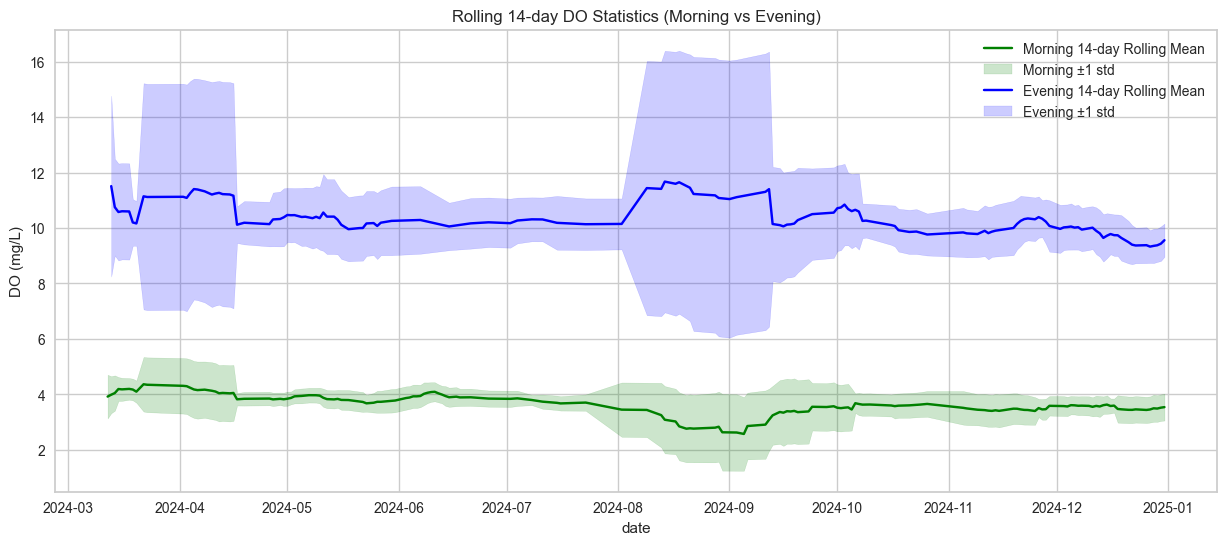

In [16]:
plot_rolling_stats(winkler_df, window=14)

C:\Users\squaade\AppData\Local\Temp\ipykernel_33836\4086724317.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\squaade\AppData\Local\Temp\ipykernel_33836\4086724317.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



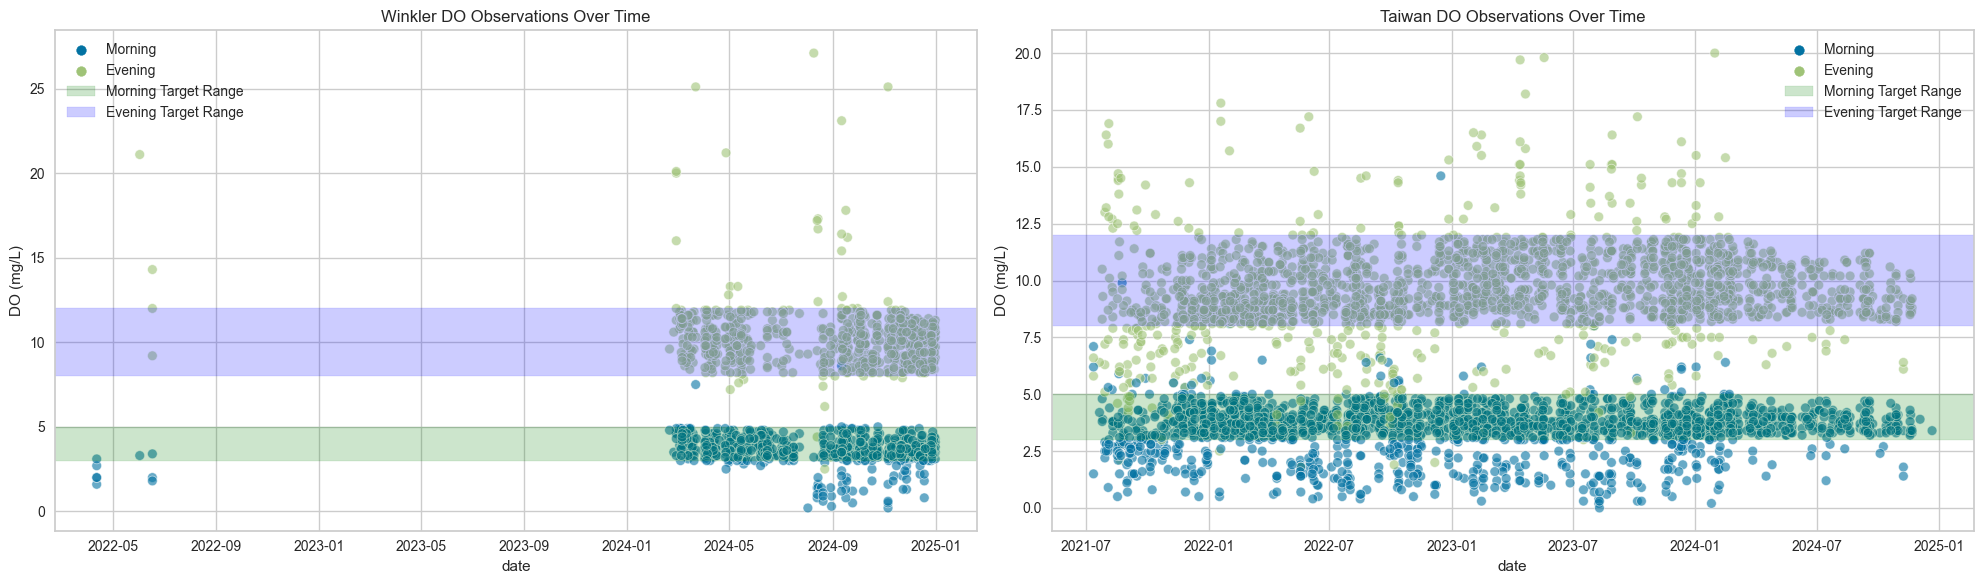

In [17]:
def plot_do_observations_with_bands(winkler_df, taiwan_df):
    """
    Plot DO observations over time with bands indicating in/out of range,
    colored by morning/evening. Creates a 1x2 subplot comparing Winkler and Taiwan data.
    
    Args:
        winkler_df: DataFrame with Winkler DO measurements
        taiwan_df: DataFrame with Taiwan DO measurements
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    for df, ax, title in [(winkler_df, ax1, 'Winkler'), (taiwan_df, ax2, 'Taiwan')]:
        # Create morning/evening labels
        df['time_of_day'] = df['sample_dt'].dt.hour.apply(lambda x: 'Morning' if x < 12 else 'Evening')
        
        # Plot scatter points
        sns.scatterplot(data=df,
                        x='date',
                        y='do_mg_per_L',
                        hue='time_of_day',
                        alpha=0.6,
                        ax=ax)
        
        # Add bands for acceptable DO ranges
        # Morning range: ~3-5 mg/L
        ax.axhspan(3, 5, alpha=0.2, color='green', label='Morning Target Range')
        # Evening range: ~8-12 mg/L  
        ax.axhspan(8, 12, alpha=0.2, color='blue', label='Evening Target Range')
        
        ax.set_title(f'{title} DO Observations Over Time')
        ax.set_ylabel('DO (mg/L)')
        ax.legend(title='')
    
    plt.tight_layout()
    plt.show()

plot_do_observations_with_bands(winkler_df, taiwan_df)


C:\Users\squaade\AppData\Local\Temp\ipykernel_33836\1118345735.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\squaade\AppData\Local\Temp\ipykernel_33836\1118345735.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\squaade\AppData\Local\Temp\ipykernel_33836\1118345735.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

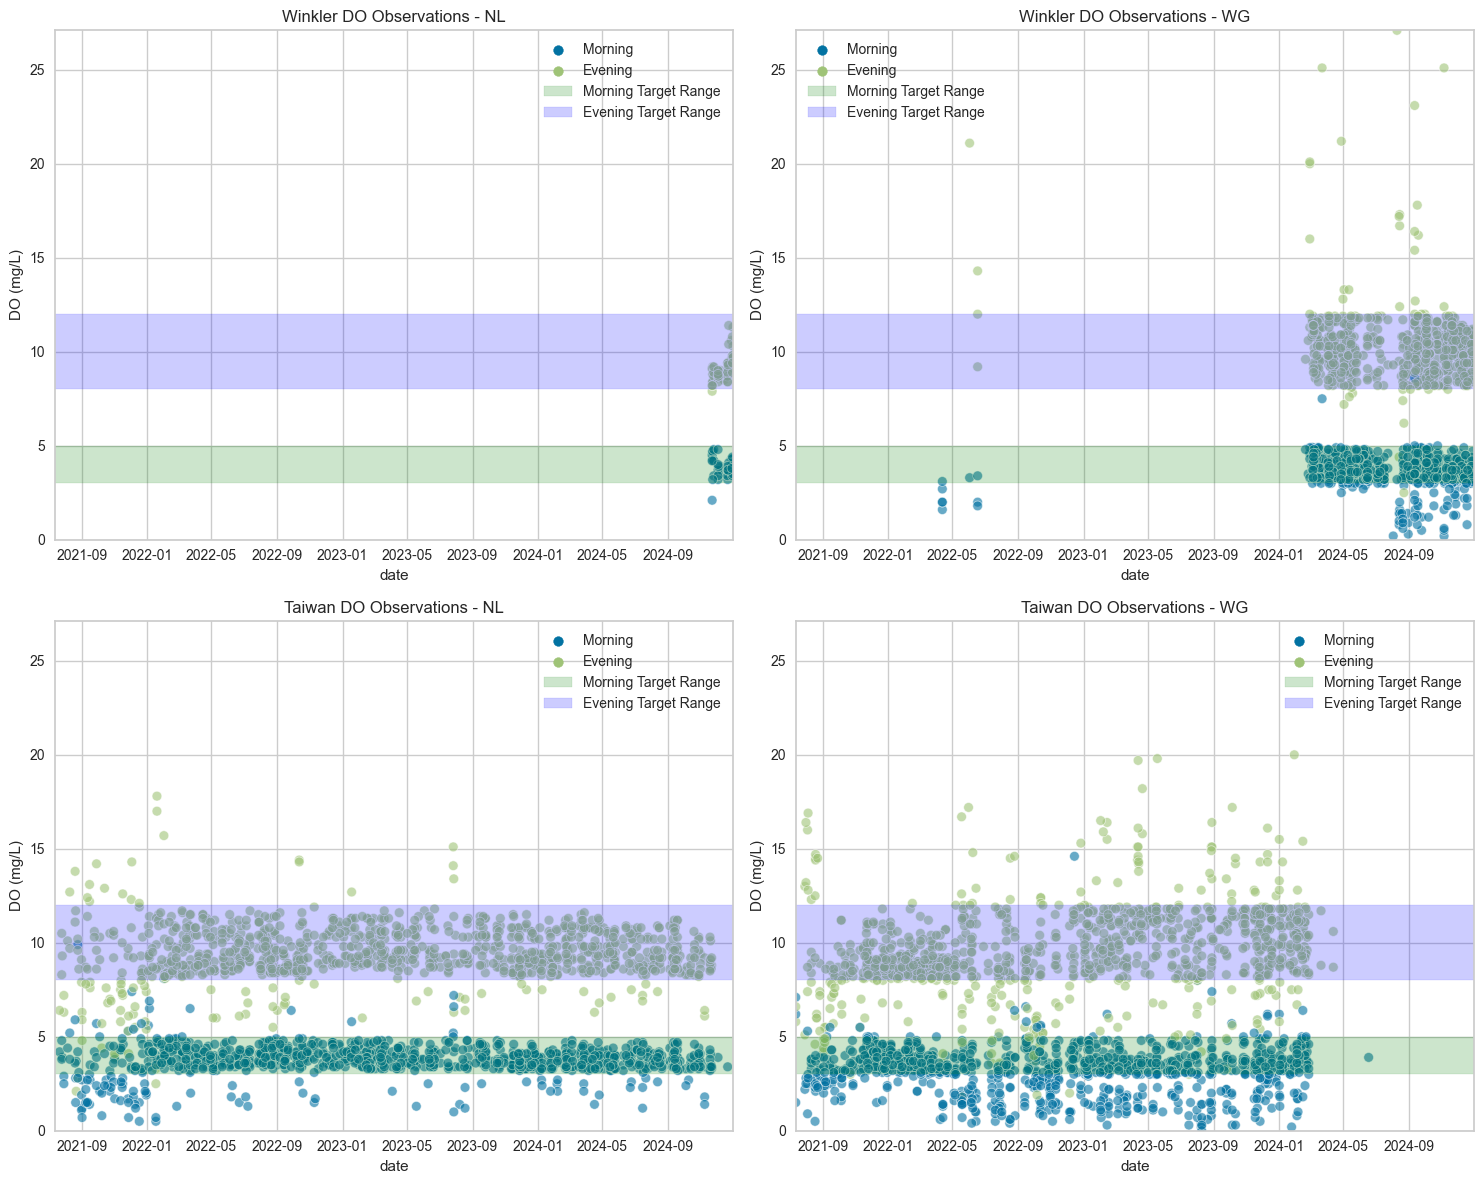

In [18]:
def plot_do_observations_with_bands_by_region(winkler_df, taiwan_df):
    """
    Plot DO observations by day of year with bands indicating in/out of range,
    colored by morning/evening. Creates a 2x2 subplot comparing Winkler and Taiwan data
    across different regions.
    
    Args:
        winkler_df: DataFrame with Winkler DO measurements
        taiwan_df: DataFrame with Taiwan DO measurements
    """
    regions = set(winkler_df['region'].unique().tolist() + taiwan_df['region'].unique().tolist())
    fig, axes = plt.subplots(len(regions), 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Find global min and max for x and y axes
    min_date = min(winkler_df['date'].min(), taiwan_df['date'].min())
    max_date = max(winkler_df['date'].max(), taiwan_df['date'].max())
    min_do = min(winkler_df['do_mg_per_L'].min(), taiwan_df['do_mg_per_L'].min())
    max_do = max(winkler_df['do_mg_per_L'].max(), taiwan_df['do_mg_per_L'].max())
    
    plot_idx = 0
    for df, title in [(winkler_df, 'Winkler'), (taiwan_df, 'Taiwan')]:
        for region in regions:
            ax = axes[plot_idx]
            region_df = df[df['region'] == region]
            
            region_df['time_of_day'] = region_df['sample_dt'].dt.hour.apply(lambda x: 'Morning' if x < 12 else 'Evening')
            
            sns.scatterplot(data=region_df,
                            x='date',
                            y='do_mg_per_L',
                            hue='time_of_day',
                            alpha=0.6,
                            ax=ax)
            
            ax.axhspan(3, 5, alpha=0.2, color='green', label='Morning Target Range')
            ax.axhspan(8, 12, alpha=0.2, color='blue', label='Evening Target Range')
            
            ax.set_title(f'{title} DO Observations - {region}')
            ax.set_ylabel('DO (mg/L)')
            ax.legend(title='')
            
            # Set standardized x and y axes
            ax.set_xlim(min_date, max_date)
            ax.set_ylim(min_do, max_do)
            
            plot_idx += 1
    
    plt.tight_layout()
    plt.show()

plot_do_observations_with_bands_by_region(winkler_df, taiwan_df)

C:\Users\squaade\AppData\Local\Temp\ipykernel_33836\2715338224.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\squaade\AppData\Local\Temp\ipykernel_33836\2715338224.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\squaade\AppData\Local\Temp\ipykernel_33836\2715338224.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

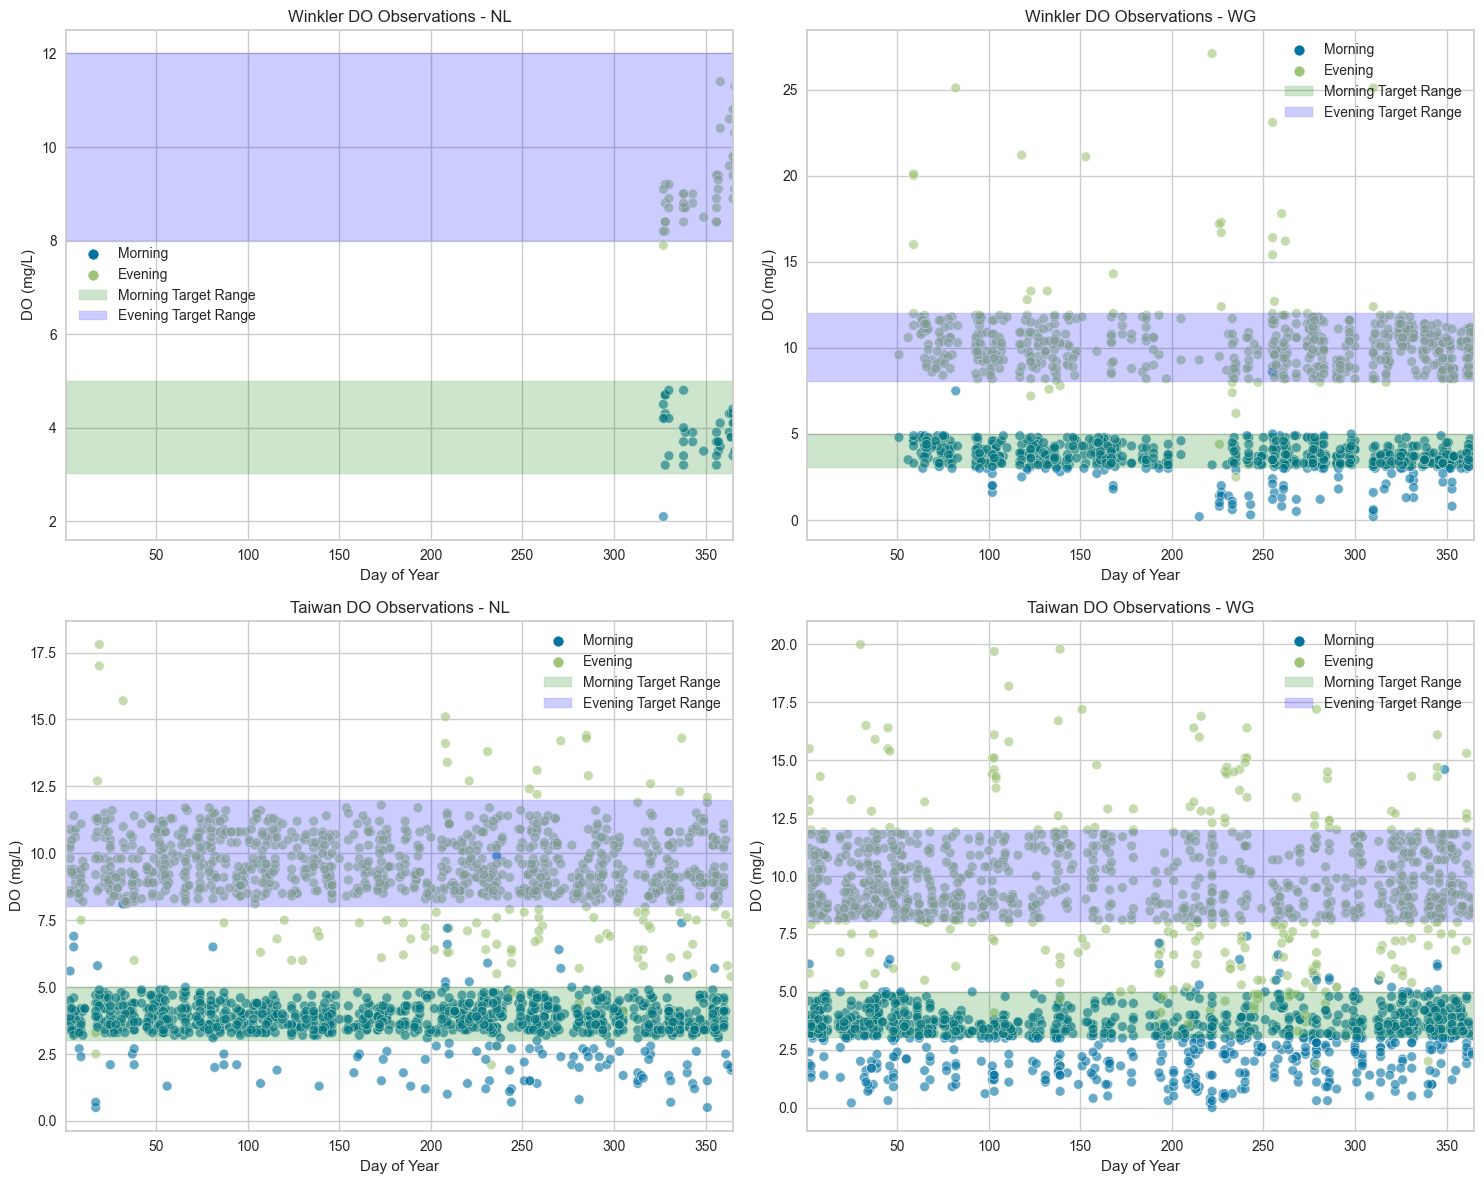

In [19]:
def plot_do_observations_with_bands_by_region(winkler_df, taiwan_df):
    """
    Plot DO observations by day of year with bands indicating in/out of range,
    colored by morning/evening. Creates a 2x2 subplot comparing Winkler and Taiwan data
    across different regions.
    
    Args:
        winkler_df: DataFrame with Winkler DO measurements
        taiwan_df: DataFrame with Taiwan DO measurements
    """
    # Create figure with four subplots (2x2)
    regions = set(winkler_df['region'].unique().tolist() + taiwan_df['region'].unique().tolist())
    fig, axes = plt.subplots(len(regions), 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Process each dataset and region combination
    plot_idx = 0
    for df, title in [(winkler_df, 'Winkler'), (taiwan_df, 'Taiwan')]:
        for region in regions:
            ax = axes[plot_idx]
            region_df = df[df['region'] == region]
            
            # Create morning/evening labels and day of year
            region_df['time_of_day'] = region_df['sample_dt'].dt.hour.apply(lambda x: 'Morning' if x < 12 else 'Evening')
            region_df['day_of_year'] = region_df['sample_dt'].dt.dayofyear
            
            # Plot scatter points
            sns.scatterplot(data=region_df,
                          x='day_of_year',
                          y='do_mg_per_L',
                          hue='time_of_day',
                          alpha=0.6,
                          ax=ax)
            
            # Add bands for acceptable DO ranges
            ax.axhspan(3, 5, alpha=0.2, color='green', label='Morning Target Range')
            ax.axhspan(8, 12, alpha=0.2, color='blue', label='Evening Target Range')
            
            ax.set_title(f'{title} DO Observations - {region}')
            ax.set_xlabel('Day of Year')
            ax.set_ylabel('DO (mg/L)')
            ax.legend(title='')
            
            # Set x-axis limits to full year
            ax.set_xlim(1, 365)
            
            plot_idx += 1
    
    plt.tight_layout()
    plt.show()

plot_do_observations_with_bands_by_region(winkler_df, taiwan_df)


We seem to have far more water quality issues in WG than in Nellore

In [20]:
def plot_do_heatmap(df):
    """
    Create a heatmap showing DO patterns by hour and month.
    
    Args:
        df: DataFrame with DO measurements
    """
    # Create pivot table
    pivot_data = df.pivot_table(
        values='do_mg_per_L',
        index='hour',
        columns='month',
        aggfunc='mean'
    )
    
    # Sort the columns (months) in chronological order
    month_order = sorted(pivot_data.columns, key=lambda x: pd.to_datetime(x, format='%B').month if isinstance(x, str) else x)
    pivot_data = pivot_data[month_order]
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_data, 
                cmap='RdYlBu_r',
                center=np.mean(df['do_mg_per_L']),
                annot=True,
                fmt='.1f')
    plt.title('DO Levels by Hour and Month')
    plt.show()

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



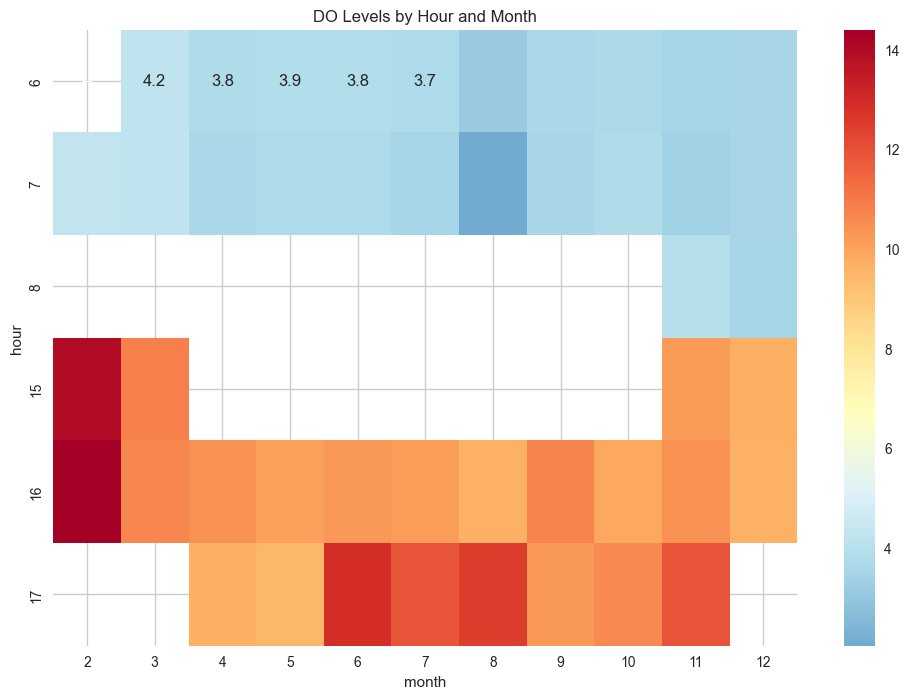

In [21]:
plot_do_heatmap(winkler_df)

In [22]:
# Get demeaned values
hourly_means = winkler_df.groupby('hour')['do_mg_per_L'].mean()
winkler_df['do_mg_per_L_demeaned'] = winkler_df.apply(lambda x: x['do_mg_per_L'] - hourly_means[x['hour']], axis=1)

C:\Users\squaade\AppData\Local\Temp\ipykernel_33836\1552332173.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



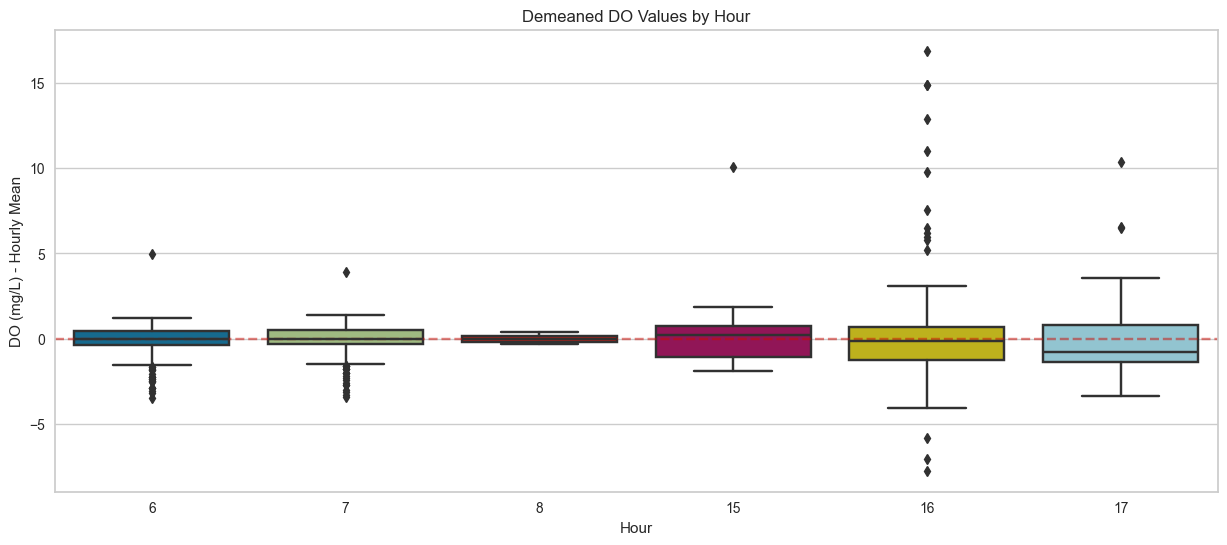

In [23]:
# Create boxplot of demeaned DO values by hour
plt.figure(figsize=(15, 6))
sns.boxplot(data=winkler_df, x='hour', y='do_mg_per_L_demeaned')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.title('Demeaned DO Values by Hour')
plt.xlabel('Hour')
plt.ylabel('DO (mg/L) - Hourly Mean')
plt.show()

In [ ]:
def plot_do_correlation_heatmap(df):
    """
    Create a correlation heatmap comparing DO correlations between Winkler and non-Winkler measurements.
    
    Args:
        df: DataFrame containing DO measurements and indicator for Winkler method
    """
    # Select numeric columns only
    numeric_cols = df.select_dtypes(include=['float64', 'int64', 'bool']).columns
    # Calculate correlations separately for Winkler and non-Winkler measurements
    # For raw DO values
    winkler_corr = df[df['do_winkler']][numeric_cols].corr()['do_mg_per_L']
    non_winkler_corr = df[~df['do_winkler']][numeric_cols].corr()['do_mg_per_L']
    
    # Combine correlations
    correlations = pd.DataFrame({
        'DO (Winkler)': winkler_corr,
        'DO (Non-Winkler)': non_winkler_corr
    })
    
    # Drop DO and Winkler indicator rows
    correlations = correlations.drop(['do_mg_per_L', 'do_winkler'])
    
    # Sort by absolute correlation with Winkler measurements
    correlations = correlations.reindex(
        correlations['DO (Winkler)'].abs().sort_values(ascending=False).index
    )
    
    # Create heatmap
    plt.figure(figsize=(12, 40))
    sns.heatmap(
        correlations,
        cmap='RdBu_r',
        center=0,
        vmin=-1,
        vmax=1,
        annot=True,
        fmt='.2f',
        cbar_kws={'label': 'Correlation Coefficient'},
        xticklabels=['DO (Winkler)', 'DO (Non-Winkler)']
    )
    
    # Move title up and x labels to top
    plt.title('Feature Correlations: Winkler vs Non-Winkler DO Measurements', pad=20)
    plt.xlabel('')
    plt.ylabel('Features')
    ax = plt.gca()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.show()

plot_do_correlation_heatmap(predict_df)

KeyError: 'do_mg_per_L_demeaned'

In [211]:
winkler_df.columns.tolist()

['sample_dt',
 'pond_id',
 'region',
 'farm',
 'morning',
 'hour',
 'do_mg_per_L',
 'do_winkler',
 'prev_matches_time',
 'prev_sample_dt',
 'prev_do_mg_per_L',
 'prev_ph',
 'prev_turbidity_cm',
 'prev_ammonia_mg_per_L',
 'prev_individuals_air_gulping',
 'prev_individuals_tail_splashing',
 'prev_dead_fish',
 'prev_feed_amount_kg',
 'prev_stocking_density_per_acre',
 'prev_weight',
 'prev_species_catla',
 'prev_species_rohu',
 'prev_species_roopchand',
 'prev_species_grass_carp',
 'prev_species_pangasius',
 'prev_species_whiteleg_shrimp',
 'property_area_acres',
 'pond_area_acres',
 'pond_depth_meters',
 'has_water_pump',
 'has_aerator',
 'has_motor_boat',
 'has_sprinkler',
 'pond_preparation',
 'village',
 'fertilizer_manure',
 'fertilizer_dap',
 'fertilizer_potash',
 'fertilizer_urea',
 'fertilizer_phosphate',
 'fertilizer_amm_sulph',
 'fertilizer_probiotics',
 'fertilizer_magnesium',
 'fertilizer_gromor',
 'fertilizer_lime',
 'fertilizer_none',
 'feed_type',
 'feed_source',
 'feed_bra

In [252]:
target = 'do_mg_per_L'
test_cols = ['hour']
test_cols = (
  test_cols + 
  winkler_df.columns[winkler_df.columns.str.contains('downward_')].tolist() + 
  winkler_df.columns[winkler_df.columns.str.contains('precip_')].tolist() +
  winkler_df.columns[winkler_df.columns.str.contains('humidity')].tolist() +
  winkler_df.columns[winkler_df.columns.str.contains('temperature')].tolist() +
  winkler_df.columns[winkler_df.columns.str.contains('cloud_cover')].tolist() + 
  ['prev_do_mg_per_L', 'prev_ph', 'prev_dead_fish', 'prev_weight', 'prev_stocking_density_per_acre', 'do_winkler']
)

test_df = predict_df.sort_values('sample_dt')[test_cols + [target]]
test_df = test_df[test_df[target].notna()]

In [253]:
import numpy as np
from scipy.stats import randint, uniform
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tabpfn import TabPFNRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd


def time_series_train_test_split(df, target_col, test_size=0.1, date_col='sample_dt'):
    """
    Split a dataframe into train and test sets respecting time order.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to split
    target_col : str
        The name of the target column
    test_size : float, default=0.2
        The proportion of the dataset to include in the test split
    date_col : str, optional
        The name of the date column. If None, assumes data is already sorted by time
        
    Returns:
    --------
    X_train, X_test, y_train, y_test : numpy arrays
        The train and test splits
    """
    if date_col is not None and date_col in df.columns:
        df = df.sort_values(by=date_col).reset_index(drop=True)
        
        # Get the date of the split point
        split_idx = int(len(df) * (1 - test_size))
        split_date = df[date_col].iloc[split_idx].date()
        
        # Ensure no same-day data leakage by moving split point to next day
        while split_idx < len(df) and df[date_col].iloc[split_idx].date() == split_date:
            split_idx += 1
    else:
        split_idx = int(len(df) * (1 - test_size))
    
    # Split data
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]
    # Extract features and target
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]
    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]
    
    return X_train, X_test, y_train, y_test


def prepare_data(df, target_col, categorical_cols=None, test_size=0.2, date_col=None):
    """
    Prepare data for modeling by handling categorical features and scaling.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to prepare
    target_col : str
        The name of the target column
    categorical_cols : list, optional
        List of categorical column names
    test_size : float, default=0.2
        The proportion of the dataset to include in the test split
    date_col : str, optional
        The name of the date column for time-based splitting
        
    Returns:
    --------
    X_train, X_test, y_train, y_test, feature_names, scaler
    """
    # Make a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Handle categorical features
    if categorical_cols is not None:
        # Get indices of categorical columns for TabPFN
        categorical_indices = [df_copy.columns.get_loc(col) for col in categorical_cols if col in df_copy.columns]
    
    # Split data
    X_train, X_test, y_train, y_test = time_series_train_test_split(
        df_copy, target_col, test_size=test_size, date_col=date_col
    )
    
    # Scale features
    scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)
    
    # Get feature names
    feature_names = X_train.columns.tolist()
    
    return X_train, X_test, y_train.values, y_test.values, feature_names, scaler, categorical_indices


def train_tabpfn_regressor(X_train, y_train, device='cpu', categorical_indices=None):
    """
    Train a TabPFN regressor with post-hoc ensembling.
    
    Parameters:
    -----------
    X_train : numpy.ndarray
        Training features
    y_train : numpy.ndarray
        Training target values
    N_ensemble_configurations : int, default=32
        Number of ensemble configurations
    device : str, default='cpu'
        Device to use for training ('cpu' or 'cuda')
        
    Returns:
    --------
    model : TabPFNRegressor
        Trained TabPFN model
    """
    # Create time series cross-validation splits
    tscv = TimeSeriesSplit(n_splits=2)
    
    # Define XGBoost model and parameter grid
    model = XGBRegressor(random_state=42, n_jobs=psutil.cpu_count(logical=False) - 1)
    
    param_distributions = {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'min_child_weight': randint(1, 7),
        'gamma': uniform(0, 0.5),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0, 1)
    }
    
    # Perform randomized search with time series CV
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=250,  # Number of parameter settings sampled
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=psutil.cpu_count(logical=False) - 1,
        verbose=1,
        random_state=42
    )
    
    # Fit the model
    random_search.fit(X_train, y_train)
    
    # Get best model
    best_model = random_search.best_estimator_
    
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best CV score: {-random_search.best_score_:.4f} MSE")
    
    return best_model


def evaluate_regression_model(model, X_test, y_test):
    """
    Evaluate a regression model and return predictions and metrics.
    
    Parameters:
    -----------
    model : trained model
        The model to evaluate
    X_test : numpy.ndarray
        Test features
    y_test : numpy.ndarray
        True target values
        
    Returns:
    --------
    dict containing predictions and evaluation metrics
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate regression metrics
    results = {
        'y_pred': y_pred,
        'y_true': y_test,
        'mse': mean_squared_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred)
    }
  
    return results


def plot_regression_results(results, model, X_train, X_test, y_train, title="Regression Model Evaluation"):
    """
    Plot regression results including predicted vs actual values and residuals using yellowbrick.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing evaluation results
    model : trained model
        The model to use for the residuals plot
    X_train : array-like
        Training features
    X_test : array-like 
        Test features
    y_train : array-like
        Training target values
    title : str, default="Regression Model Evaluation"
        Title for the plot
    """
    y_true = results['y_true']
    y_pred = results['y_pred']
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Predicted vs Actual
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    axes[0].set_xlabel('Actual Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].set_title('Predicted vs Actual')
    
    # Add metrics as text
    metrics_text = f"RMSE: {results['rmse']:.4f}\nMAE: {results['mae']:.4f}\nR²: {results['r2']:.4f}"
    axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes, 
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Residuals using yellowbrick
    visualizer = ResidualsPlot(model, ax=axes[1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, results['y_true'])
    visualizer.finalize()
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


def plot_time_series_predictions(df, date_col, actual_col, pred_col, title="Time Series Predictions"):
    """
    Plot time series predictions against actual values.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the date, actual values, and predictions
    date_col : str
        Name of the date column
    actual_col : str
        Name of the column with actual values
    pred_col : str
        Name of the column with predicted values
    title : str, default="Time Series Predictions"
        Title for the plot
    """
    plt.figure(figsize=(15, 6))
    plt.plot(df[date_col], df[actual_col], 'b-', label='Actual')
    plt.plot(df[date_col], df[pred_col], 'r--', label='Predicted')
    plt.fill_between(df[date_col], df[actual_col], df[pred_col], color='gray', alpha=0.2)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_feature_importance(model, feature_names, top_n=20, title="Feature Importance"):
    """
    Plot feature importance if available from the model.
    
    Parameters:
    -----------
    model : trained model
        The model with feature_importances_ attribute
    feature_names : list
        List of feature names
    top_n : int, default=20
        Number of top features to display
    title : str, default="Feature Importance"
        Title for the plot
    """
    if hasattr(model, 'feature_importances_'):
        # Get feature importances
        importances = model.feature_importances_
        
        # Create DataFrame for plotting
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        
        # Sort by importance and take top N
        importance_df = importance_df.sort_values('Importance', ascending=False).head(top_n)
        
        # Plot
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(title)
        plt.tight_layout()
        plt.show()
    else:
        print("Model does not provide feature importances.")


def run_do_prediction_pipeline(df, target_col='do_mg_per_L', test_size=0.2, 
                              date_col=None, categorical_cols=None):
    """
    Run the complete dissolved oxygen prediction pipeline.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe
    target_col : str, default='do_mg_per_L'
        The target column name
    test_size : float, default=0.2
        Proportion of data to use for testing
    date_col : str, optional
        Date column for time-based splitting
    categorical_cols : list, optional
        List of categorical columns
    threshold : float, default=5.0
        Threshold for binary classification (low/high DO)
    n_ensemble : int, default=32
        Number of ensemble configurations for TabPFN
        
    Returns:
    --------
    dict containing model, results, and processed data
    """
    print("Preparing data...")
    X_train, X_test, y_train, y_test, feature_names, scaler, cat_indices = prepare_data(
        df, target_col, categorical_cols, test_size, date_col
    )
    
    print(f"Training TabPFN regressor...")
    model = train_tabpfn_regressor(X_train, y_train, categorical_indices=cat_indices)
    
    print("Evaluating model...")
    results = evaluate_regression_model(model, X_test, y_test)
    
    print("\nRegression Metrics:")
    print(f"RMSE: {results['rmse']:.4f}")
    print(f"MAE: {results['mae']:.4f}")
    print(f"R²: {results['r2']:.4f}")
    
    # Visualize results
    plot_regression_results(results, model, X_train, X_test, y_train, title="DO Prediction: Regression Results")
    # If date column is available, plot time series predictions
    if date_col is not None and date_col in df.columns:
        # Create a dataframe with predictions for time series plotting
        test_indices = df.index[-len(y_test):]
        pred_df = df.loc[test_indices].copy()
        pred_df['predicted'] = results['y_pred']
        
        print("Plotting time series predictions...")
        plot_time_series_predictions(pred_df, date_col=date_col, actual_col=target_col, 
                         						 pred_col='predicted', title="DO Predictions Over Time")
    
    # Plot feature importance if available
    print("Plotting feature importance...")
    plot_feature_importance(model, feature_names, top_n=20, 
                           title="Feature Importance for DO Prediction")
    
    # Return all relevant components
    return {
        'model': model,
        'results': results,
        'feature_names': feature_names,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler
    }

Preparing data...
Training TabPFN regressor...
Fitting 2 folds for each of 250 candidates, totalling 500 fits
Best parameters: {'colsample_bytree': 0.8586659676468653, 'gamma': 0.34658760572846237, 'learning_rate': 0.025478741997613, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 115, 'reg_alpha': 0.9252483174156658, 'reg_lambda': 0.18057534512733353, 'subsample': 0.8271780922210518}
Best CV score: 2.3710 MSE
Evaluating model...

Regression Metrics:
RMSE: 1.4569
MAE: 0.8635
R²: 0.8247


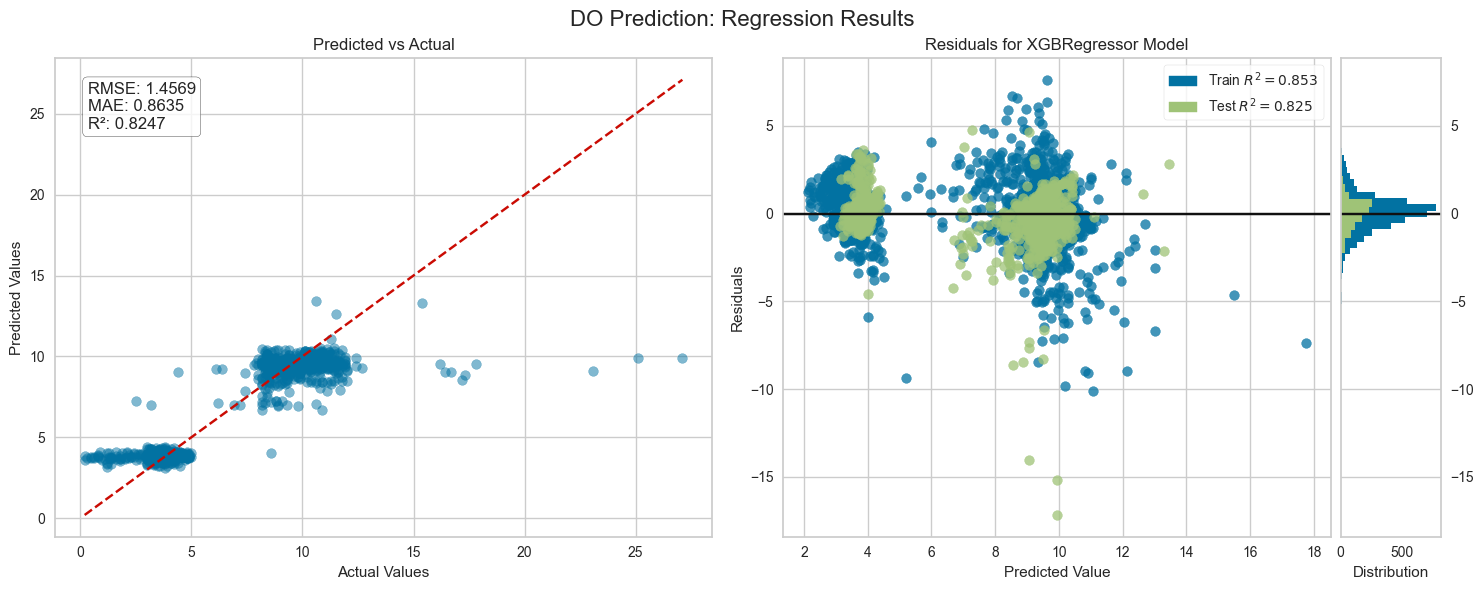

Plotting feature importance...


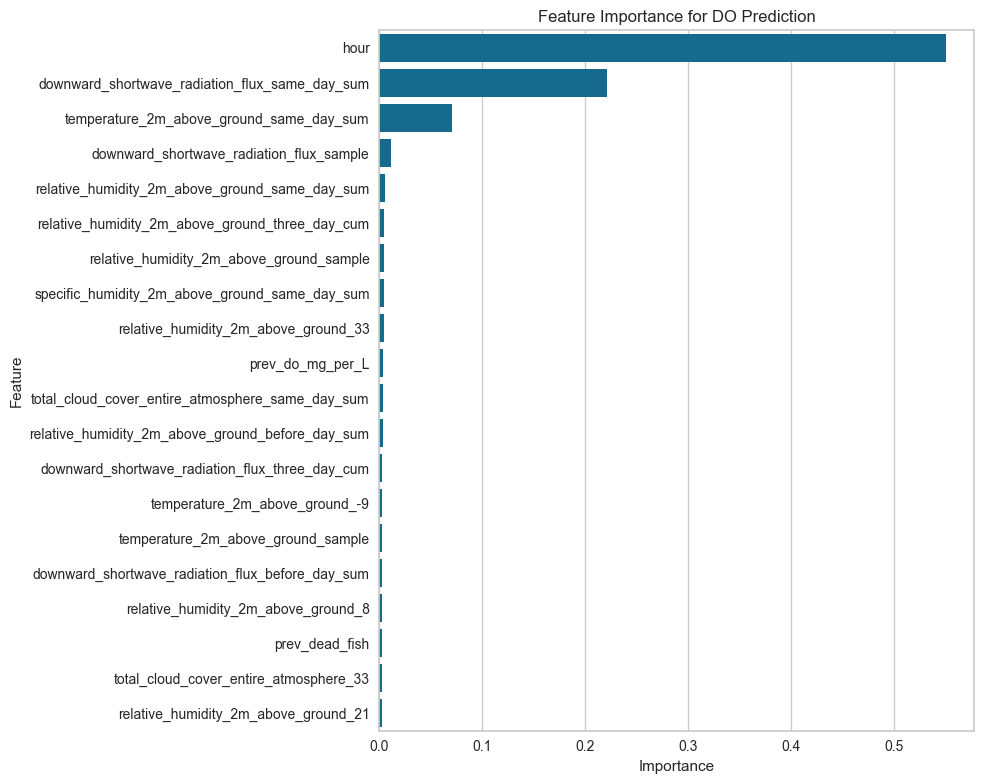

In [255]:
out = run_do_prediction_pipeline(test_df, target_col='do_mg_per_L', categorical_cols=['village', 'month'])

C:\Users\squaade\AppData\Local\Temp\ipykernel_18104\2188222353.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



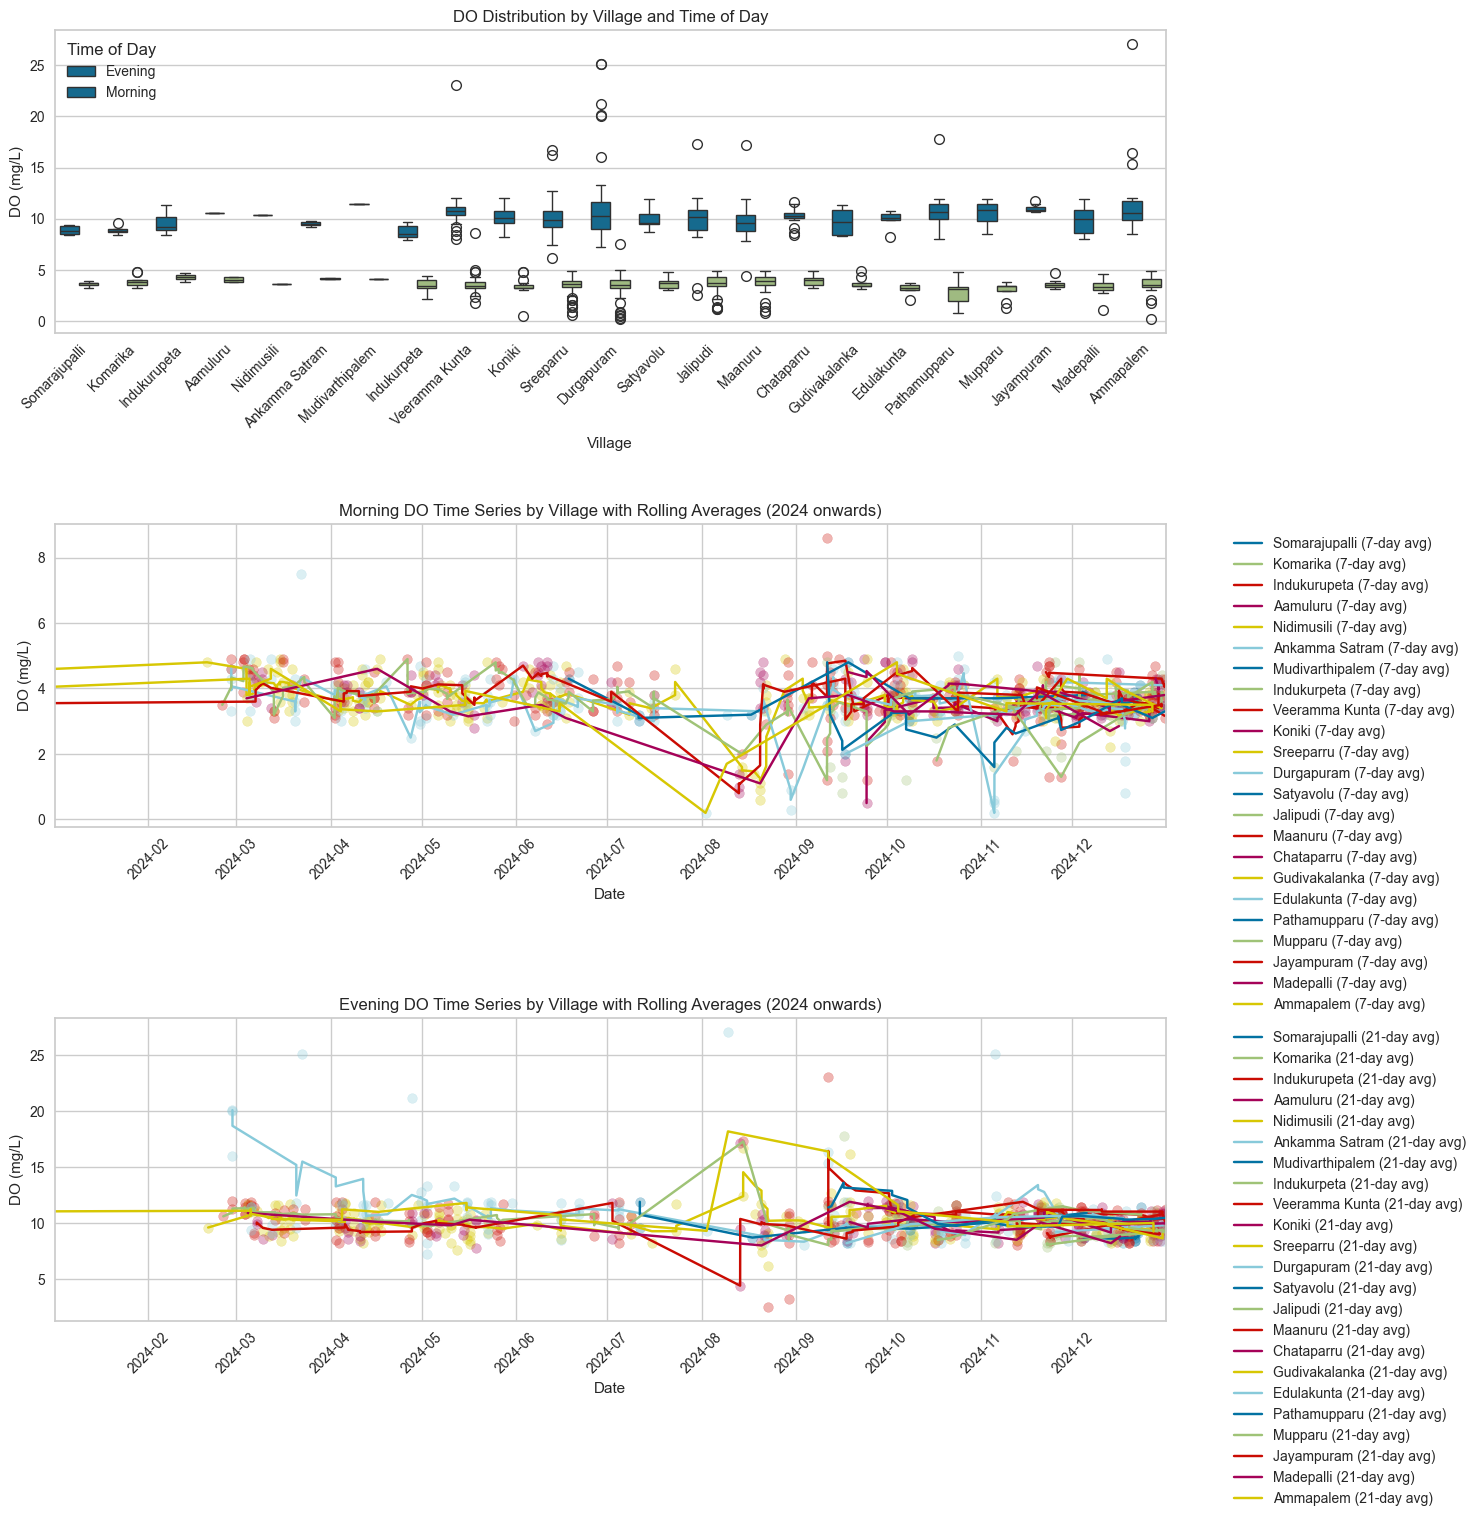

In [256]:
# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# Boxplot of DO by village and time of day
sns.boxplot(data=winkler_df, x='village', y='do_mg_per_L', hue='morning', ax=ax1)
ax1.set_title('DO Distribution by Village and Time of Day')
ax1.set_xlabel('Village')
ax1.set_ylabel('DO (mg/L)')
ax1.tick_params(axis='x', rotation=45)
ax1.set_xticklabels(ax1.get_xticklabels(), ha='right', rotation_mode='anchor')
ax1.legend(title='Time of Day', labels=['Evening', 'Morning'])

# Morning scatterplot with rolling averages
for village in winkler_df['village'].unique():
    # Morning data
    mask = (winkler_df['village'] == village) & (winkler_df['morning'] == True)
    village_data = winkler_df[mask].sort_values('sample_dt')
    
    # Plot scatter points without label
    ax2.scatter(village_data['sample_dt'], village_data['do_mg_per_L'], alpha=0.3)
    
    # Calculate and plot rolling average with label
    if len(village_data) > 0:
        rolling_avg = village_data.set_index('sample_dt')['do_mg_per_L'].rolling('7D', min_periods=1).mean()
        ax2.plot(rolling_avg.index, rolling_avg.values, label=f'{village} (7-day avg)')

ax2.set_title('Morning DO Time Series by Village with Rolling Averages (2024 onwards)')
ax2.set_xlabel('Date')
ax2.set_ylabel('DO (mg/L)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)
ax2.set_xlim(pd.Timestamp('2024-01-01'), winkler_df['sample_dt'].max())

# Evening scatterplot with rolling averages
for village in winkler_df['village'].unique():
    # Evening data
    mask = (winkler_df['village'] == village) & (winkler_df['morning'] == False)
    village_data = winkler_df[mask].sort_values('sample_dt')
    
    # Plot scatter points without label
    ax3.scatter(village_data['sample_dt'], village_data['do_mg_per_L'], alpha=0.3)
    
    # Calculate and plot rolling average with label
    if len(village_data) > 0:
        rolling_avg = village_data.set_index('sample_dt')['do_mg_per_L'].rolling('21D', min_periods=1).mean()
        ax3.plot(rolling_avg.index, rolling_avg.values, label=f'{village} (21-day avg)')

ax3.set_title('Evening DO Time Series by Village with Rolling Averages (2024 onwards)')
ax3.set_xlabel('Date')
ax3.set_ylabel('DO (mg/L)')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.tick_params(axis='x', rotation=45)
ax3.set_xlim(pd.Timestamp('2024-01-01'), winkler_df['sample_dt'].max())

plt.tight_layout()
plt.show()